# Temperaturas Ciudades

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from datetime import datetime
from math import *
from util import *
from dateutil.relativedelta import relativedelta # $ pip install python-dateutil

plt.rcParams["figure.figsize"] = (16, 10)

In [26]:
df = pd.read_csv('data/CitiesWithAltitude.csv',parse_dates = [0])

# Tengo que agarrar del año 1841 en adelante
df = df[df['date'] >= datetime(1841,1,1)]
df.sort_values(['date','country','city'], inplace = True)

df['ordinal']= df['date'].apply(lambda x: x.toordinal())
print(df.head())

groupByCountries = df.groupby('country')
groupByCities = df.groupby('city')

             date    avg  error      city  country   long    lat  season  \
130983 1841-01-01  7.673  2.429   Elbasan  Albania  19.17  40.99       4   
1034   1841-01-01  7.673  2.429    Tirana  Albania  19.17  40.99       4   
169157 1841-01-01 -5.310  2.242    Gyumri  Armenia  44.73  40.99       4   
30261  1841-01-01 -5.310  2.242  Vanadzor  Armenia  44.73  40.99       4   
35862  1841-01-01 -5.310  2.242   Yerevan  Armenia  44.73  40.99       4   

        hemisphere  altitude  ordinal  
130983           1       126   672047  
1034             1       103   672047  
169157           1      1545   672047  
30261            1      1320   672047  
35862            1      1002   672047  


## Ciudades de EEUU

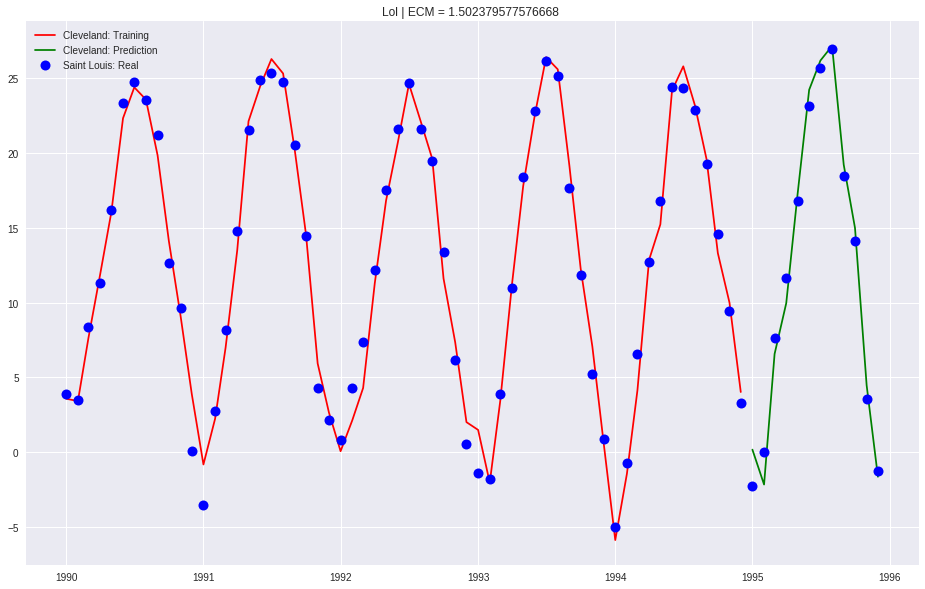

In [51]:
# Test usando una ciudad como dato MISMO PERO CON ALTURA COMO VARIABLE
gUsa = pd.DataFrame(groupByCountries.get_group('United States'))
#print(gUsa.head())

cities = list(set(gUsa['city']))
#print(cities)

# Tomo cities[0] y con ella intento predecir cities[1]
cityData = cities[0]
cityWant = cities[1]

dfData = pd.DataFrame(groupByCities.get_group(cityData))
dfWant = pd.DataFrame(groupByCities.get_group(cityWant))
#print(dfData.head())
#print(dfWant.head())

# TRAINNING DATA
dfDatat = dfData.copy(deep=True)
dfWantt = dfWant.copy(deep=True)

yearFromTr = 1990
qttyYearsTr = 5
dateSince = datetime(yearFromTr, 1, 1)
dateTo = dateSince + relativedelta(years=+qttyYearsTr)
dfDatat = dfDatat[dfDatat['date'] >= dateSince]
dfDatat = dfDatat[dfDatat['date'] < dateTo]
dfWantt = dfWantt[dfWantt['date'] >= dateSince]
dfWantt = dfWantt[dfWantt['date'] < dateTo]

xsT = [[o, t] for o, t in zip(list(dfDatat['ordinal']), list(dfDatat['avg']))]
#print(len(xsT))
ysT = list(dfWantt['avg'])
#print(len(ysT))

funcion = lambda x: [x[0], x[1], 1]
fun = cml(funcion, xsT, ysT)


# PREDICTION DATA
dfDatap = dfData.copy(deep=True)

yearFromP = 1995
qttyYearsP = 1
dateSince = datetime(yearFromP, 1, 1)
dateTo = dateSince + relativedelta(years=+qttyYearsP)
dfDatap = dfDatap[dfDatap['date'] >= dateSince]
dfDatap = dfDatap[dfDatap['date'] < dateTo]

xsP = [[o, t] for o, t in zip(list(dfDatap['ordinal']), list(dfDatap['avg']))]


# IMPRIMIR
yearFromP = 1990
qttyYearsP = 6
dateSince = datetime(yearFromP, 1, 1)
dateTo = dateSince + relativedelta(years=+qttyYearsP)
dfWant = dfWant[dfWant['date'] >= dateSince]
dfWant = dfWant[dfWant['date'] < dateTo]

resT = [fun(x) for x in xsT]
resP = [fun(x) for x in xsP]

plt.plot(list(dfDatat['date']), resT, 'r', label=cityData+': Training', color='red')
plt.plot(list(dfDatap['date']), resP, 'r', label=cityData+': Prediction', color='green')

plt.plot(list(dfWant['date']), list(dfWant['avg']), 'o', label=cityWant+': Real', markersize=10, color='blue')

plt.title('{} | ECM = {} '.format('Lol', ecm(resT+resP, ysT+ysP)))
plt.legend()
#print(ecm(resT, ys))

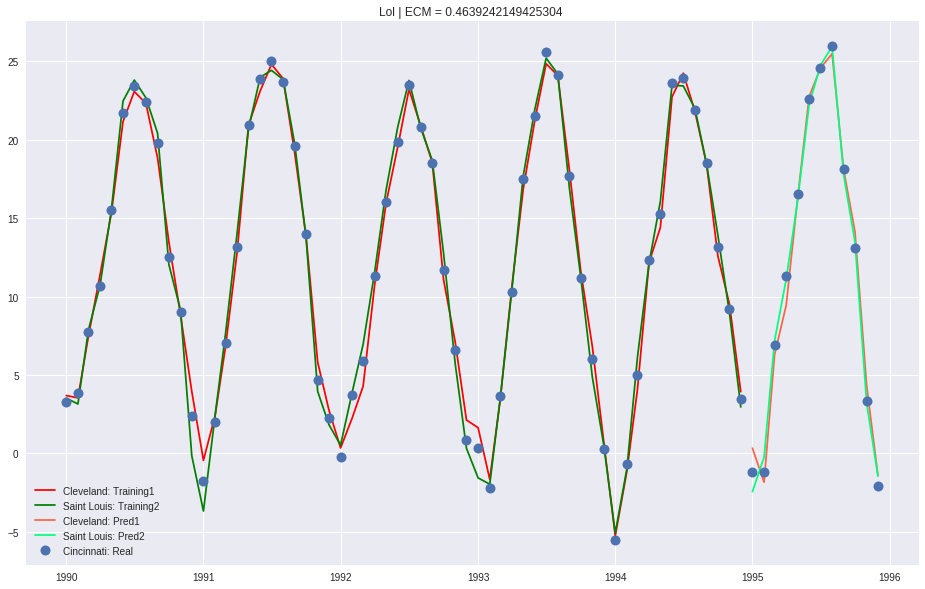

In [53]:
# Test usando 2 ciudades como dato
gUsa = pd.DataFrame(groupByCountries.get_group('United States'))
#print(gUsa.head())

cities = list(set(gUsa['city']))
#print(cities)

# Tomo cities[0] y cities[1] con ellas intento predecir cities[2]
cityData1 = cities[0]
cityData2 = cities[1]
cityWant = cities[2]
dfData1 = pd.DataFrame(groupByCities.get_group(cityData1))
dfData2 = pd.DataFrame(groupByCities.get_group(cityData2))
dfWant = pd.DataFrame(groupByCities.get_group(cityWant))


#TRAINING DATA
dfData1t = dfData1.copy(deep=True)
dfData2t = dfData2.copy(deep=True)
dfWantt = dfWant.copy(deep=True)
#print(dfData1t.head())
#print(dfData2t.head())
#print(dfWantt.head())

yearFromTr = 1990
qttyYearsTr = 5
dateSince = datetime(yearFromTr, 1, 1)
dateTo = dateSince + relativedelta(years=+qttyYearsTr)
dfData1t = dfData1t[dfData1t['date'] >= dateSince]
dfData1t = dfData1t[dfData1t['date'] < dateTo]
dfData2t = dfData2t[dfData2t['date'] >= dateSince]
dfData2t = dfData2t[dfData2t['date'] < dateTo]
dfWantt = dfWantt[dfWantt['date'] >= dateSince]
dfWantt = dfWantt[dfWantt['date'] < dateTo]

xsD1t = [[o, t] for o, t in zip(list(dfData1t['altitude']),list(dfData1t['avg']))]
xsD2t = [[o, t] for o, t in zip(list(dfData2t['altitude']), list(dfData2t['avg']))]
xsT = xsD1t + xsD2t
#print(len(xsT))

ysT = list(dfWantt['avg']) + list(dfWantt['avg'])
#print(len(ysT))

funcion = lambda x: [x[0], x[1], 1]
fun = cml(funcion, xsT, ysT)


# PREDICTION DATA
dfData1p = dfData1.copy(deep=True)
dfData2p = dfData2.copy(deep=True)

yearFromP = 1995
qttyYearsP = 1
dateSince = datetime(yearFromP, 1, 1)
dateTo = dateSince + relativedelta(years=+qttyYearsP)
dfData1p = dfData1p[dfData1p['date'] >= dateSince]
dfData1p = dfData1p[dfData1p['date'] < dateTo]
dfData2p = dfData2p[dfData2p['date'] >= dateSince]
dfData2p = dfData2p[dfData2p['date'] < dateTo]

xsD1p = [[o, t] for o, t in zip(list(dfData1p['altitude']),list(dfData1p['avg']))]
xsD2p = [[o, t] for o, t in zip(list(dfData2p['altitude']), list(dfData2p['avg']))]
xsP = xsD1p + xsD2p
#print(len(xsP))


# Imprimo
yearFromP = 1990
qttyYearsP = 6
dateSince = datetime(yearFromP, 1, 1)
dateTo = dateSince + relativedelta(years=+qttyYearsP)
dfWant = dfWant[dfWant['date'] >= dateSince]
dfWant = dfWant[dfWant['date'] < dateTo]

resD1t = [fun(x) for x in xsD1t]
resD2t = [fun(x) for x in xsD2t]
resD1p = [fun(x) for x in xsD1p]
resD2p = [fun(x) for x in xsD2p]

plt.plot(list(dfData1t['date']), resD1t, 'r', label=cityData1+': Training1', color='red')
plt.plot(list(dfData2t['date']), resD2t, 'r', label=cityData2+': Training2', color='green')

plt.plot(list(dfData1p['date']), resD1p, 'r', label=cityData1+': Pred1', color='tomato')
plt.plot(list(dfData2p['date']), resD2p, 'r', label=cityData2+': Pred2', color='springgreen')
#plt.plot(list(dfData2p['date']) + list(dfData1p['date']), resD2p + resD1p, 'r', label='Prediccion ambas ciudades', color='springgreen')

plt.plot(list(dfWant['date']), list(dfWant['avg']), 'o', label=cityWant+': Real', markersize=10)

# Calculo el ECM solo de la  parte de training
ecmTotal = ecm([fun(x) for x in xsT] , ysT)

plt.title('{} | ECM = {} '.format('Lol', ecmTotal))
plt.legend()